In [33]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep'''
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.compose import ColumnTransformer 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import precision_recall_curve, average_precision_score,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# Data Preparation

## Acquire Data

In [42]:
# We only get the train data set
current_path = os.getcwd()+"\\"
file = os.path.sep.join(["train.csv"])
data = pd.read_csv(current_path + file)
data=data.set_index("Id")

# signal is the target variable
X=data.drop(["signal","BUTTER"], axis=1) # Droping BUTTER variable as is IRRELEVANT
y=pd.DataFrame(data["signal"])


## Explore Data

In [43]:
X.shape

(212662, 14)

In [45]:
X.head()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
Id,,,,,,,,,,,,,,
0,28.878847,2.662533,2924.690991,0.999997,19085.568945,0.569198,-0.575502,0.581565,66850.893711,0.637969,14298.486178,7940.694301,2.628526,2.680116
1,34.233566,0.092746,346.948714,0.999997,6631.244546,0.248707,-0.615941,0.277898,39274.475071,0.148815,11553.163934,3904.681337,3.292504,3.085754
2,36.113632,2.442423,238.553023,0.999986,7740.918989,0.222347,0.249383,0.216576,27757.153899,0.249840,24081.196003,4738.891687,3.433676,3.121906
3,14.286133,6.337556,227.375132,0.999806,6740.281614,0.347316,0.591884,0.306927,10593.207077,0.400748,11343.521945,3308.943750,2.291867,2.200712
4,60.474274,7.632751,106.730650,0.999905,5556.388794,0.204273,0.655850,0.196600,11801.249543,0.223101,25940.693317,4026.326871,3.290073,3.281829


In [46]:
X.describe()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
count,212662.000000,212662.000000,2.126620e+05,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000,212662.000000
mean,30.917255,2.831039,3.233108e+03,0.999962,9260.664335,0.573487,0.217185,0.581601,29740.464140,0.595178,23615.399265,5781.262866,3.149949,3.166745
std,15.392944,2.216654,1.498588e+04,0.000068,3997.768903,0.417256,0.484779,0.437939,19239.085505,0.460742,16424.509733,2669.985983,0.520862,0.527135
min,0.204442,0.000038,3.138746e+01,0.999500,2500.513932,0.200005,-0.799991,0.064412,3791.228140,0.053244,4952.118133,3000.031840,2.000000,2.000227
25%,19.250309,0.925412,3.851386e+02,0.999961,6527.503234,0.289879,-0.170048,0.292138,15356.298104,0.294970,11921.223058,3887.726863,2.752651,2.760779
50%,29.615744,2.287488,9.017917e+02,0.999989,8336.548930,0.429935,0.241336,0.436257,24379.336211,0.444553,18693.423754,4986.055993,3.128397,3.151240
75%,41.071903,4.426295,2.564877e+03,0.999998,11065.050625,0.703082,0.634683,0.713462,38994.138332,0.731249,30209.322530,6770.025065,3.526473,3.551590
max,108.067413,7.999920,1.971087e+06,1.000000,56327.186960,2.999445,0.999998,4.376841,99995.109721,4.439294,99982.936241,52715.201472,4.499751,4.499966


In [47]:
y.groupby('signal').signal.count()/y["signal"].count().sum()*100

signal
0.0    66.599581
1.0    33.400419
Name: signal, dtype: float64

## Scaling the data

In [48]:
#Standarazing all of the signal variables we could normalize them but this will be likely affected by the precense of outliers
X_scaled=X.copy()
scaler = StandardScaler() 
X_scaled[X_scaled.columns.values] = scaler.fit_transform(X_scaled[X_scaled.columns.values])

In [49]:
X_scaled.describe()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
count,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05,2.126620e+05
mean,-7.689786e-17,-2.424404e-16,1.474989e-17,6.123766e-14,5.696404e-16,7.085084e-17,-1.214572e-17,1.904297e-16,-1.719373e-16,-1.490377e-16,-3.372423e-16,3.115288e-16,-7.637162e-16,4.556852e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.995257e+00,-1.277154e+00,-2.136496e-01,-6.768457e+00,-1.690985e+00,-8.950950e-01,-2.098233e+00,-1.180966e+00,-1.348780e+00,-1.176222e+00,-1.136309e+00,-1.041667e+00,-2.207787e+00,-2.212948e+00
25%,-7.579429e-01,-8.596884e-01,-1.900439e-01,-2.022793e-02,-6.836732e-01,-6.796995e-01,-7.987847e-01,-6.609699e-01,-7.476551e-01,-6.515771e-01,-7.119971e-01,-7.091949e-01,-7.627739e-01,-7.701401e-01
50%,-8.455265e-02,-2.452133e-01,-1.555679e-01,3.952731e-01,-2.311583e-01,-3.440399e-01,4.981935e-02,-3.318836e-01,-2.786588e-01,-3.269188e-01,-2.996733e-01,-2.978326e-01,-4.137858e-02,-2.941407e-02
75%,6.596966e-01,7.196702e-01,-4.459077e-02,5.145738e-01,4.513494e-01,3.105881e-01,8.612174e-01,3.010957e-01,4.809842e-01,2.953312e-01,4.014694e-01,3.703257e-01,7.228877e-01,7.300715e-01
max,5.012059e+00,2.331845e+00,1.313142e+02,5.505127e-01,1.177323e+01,5.814091e+00,1.614789e+00,8.666168e+00,3.651671e+00,8.343331e+00,4.649619e+00,1.757839e+01,2.591483e+00,2.529191e+00


Using **Robust Scaling** to avoid outliers effect when scaling

More info in: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

In [50]:
#Robust scaled to avoid outilers effect when normalizing: 
X_Rscaled=X.copy()
Rscaler = RobustScaler() 
X_Rscaled[X_Rscaled.columns.values] = Rscaler.fit_transform(X_Rscaled[X_Rscaled.columns.values])

In [51]:
X_Rscaled.describe()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA
count,2.126620e+05,212662.000000,2.126620e+05,2.126620e+05,212662.000000,2.126620e+05,2.126620e+05,212662.000000,2.126620e+05,2.126620e+05,212662.000000,2.126620e+05,212662.000000,212662.000000
mean,5.964327e-02,0.155261,1.069539e+00,-7.391022e-01,0.203660,3.474142e-01,-3.001162e-02,0.344970,2.268028e-01,3.452486e-01,0.269135,2.758933e-01,0.027852,0.019607
std,7.053996e-01,0.633170,6.875082e+00,1.869856e+00,0.881042,1.009810e+00,6.024103e-01,1.039433,8.139105e-01,1.056071e+00,0.898098,9.263393e-01,0.673102,0.666574
min,-1.347807e+00,-0.653392,-3.993158e-01,-1.339511e+01,-1.286165,-5.564596e-01,-1.294006e+00,-0.882562,-8.709809e-01,-8.969221e-01,-0.751380,-6.890419e-01,-1.458212,-1.455484
25%,-4.750081e-01,-0.389066,-2.370252e-01,-7.769254e-01,-0.398684,-3.389516e-01,-5.112066e-01,-0.342062,-3.817201e-01,-3.428614e-01,-0.370306,-3.810602e-01,-0.485572,-0.493748
50%,-8.140357e-17,0.000000,2.607809e-17,-1.519405e-12,0.000000,6.717183e-17,1.724517e-17,0.000000,-7.695210e-17,-6.361874e-17,0.000000,1.577725e-16,0.000000,0.000000
75%,5.249919e-01,0.610934,7.629748e-01,2.230746e-01,0.601316,6.610484e-01,4.887934e-01,0.657938,6.182799e-01,6.571386e-01,0.629694,6.189398e-01,0.514428,0.506252
max,3.595139e+00,1.631712,9.038630e+02,2.902751e-01,10.576339,6.218528e+00,9.427517e-01,9.352846,3.198929e+00,9.156377e+00,4.444940,1.655941e+01,1.772181,1.705496


## Feature engineering

In [53]:
# EMPTY AT THIS POINT

# Model Training and testing

## Logistic regression

In [80]:
#Split between training and test
X_train, X_test, y_train, y_test = train_test_split(X_Rscaled, y, test_size=0.33)
k_fold = StratifiedKFold(n_splits=5,shuffle=True)

In [81]:
#penalty = 'l2'
#C = 1.0
#class_weight = 'balanced'
#n_jobs=1
#solver = 'liblinear'

#model = LogisticRegression(penalty=penalty, C=C,
            class_weight=class_weight,solver=solver, n_jobs=n_jobs)

In [109]:
model=LogisticRegression(C = 1.0)

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                          y_train.values.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    #model
    model.fit(X_train_fold,y_train_fold)
    
    print(model.score(X_train_fold,y_train_fold))
    print(model.score(X_cv_fold,y_cv_fold))
    print()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7397662870878879
0.7429203074007791



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7414507044724791
0.7373407727129172



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7401610724124015
0.7413061023967435



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7406985007062209
0.7397178551375632



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7402510812636529
0.7410162829870859



In [110]:
score=model.score(X_test,y_test)
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)

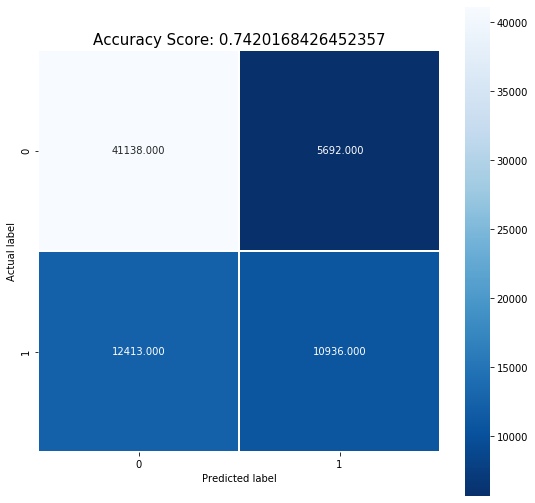

In [111]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [112]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.7913239931600058

## Random Forest

In [137]:
#Split between training and test
X_train, X_test, y_train, y_test = train_test_split(X_Rscaled, y, test_size=0.4)
k_fold = StratifiedKFold(n_splits=5,shuffle=True)

In [138]:
model = RandomForestClassifier()

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                          y_train.values.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    print(model.score(X_train_fold,y_train_fold))
    print(model.score(X_cv_fold,y_cv_fold))
    


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


0.9999804069476963
0.7718260188087774


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


0.9999902034738481
0.7720219435736677


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


1.0
0.7711900936557076


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


1.0
0.774442572201105


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


1.0
0.7742466397586112


In [139]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.8324412128991875